# Importing libraies

In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from skimage import io, color, feature, exposure
from skimage.feature import hog


# Importing Data

In [2]:
DATA_PATH = 'cell_images'
INFECTED_PATH = os.path.join(DATA_PATH, 'Parasitized')
UNINFECTED_PATH = os.path.join(DATA_PATH, 'Uninfected')

In [3]:
infected_samples = os.listdir(INFECTED_PATH) 
len(infected_samples)

13738

In [4]:
uninfected_samples = os.listdir(UNINFECTED_PATH) 
len(uninfected_samples)

13780

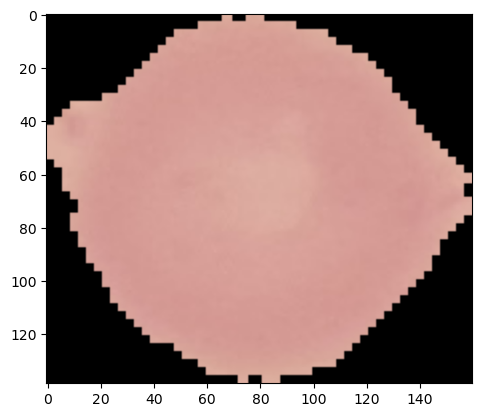

In [5]:
img = cv2.imread(os.path.join(UNINFECTED_PATH,uninfected_samples[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

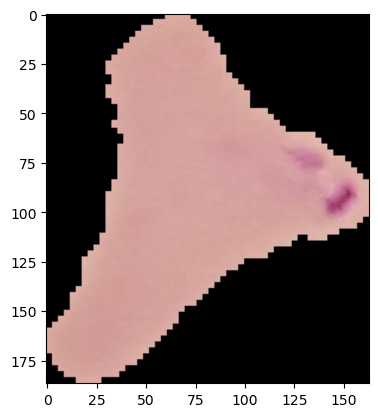

In [6]:
# Infected Image
img = cv2.imread(os.path.join(INFECTED_PATH,infected_samples[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Preprocessing 

In [7]:
img_size = (75, 75)
X = []
y = []
labels = {'Parasitized': 1, 'Uninfected': 0}

# Load 500 images for each label (adjust the number as needed)
num_images_per_label = 1000

for label in os.listdir(DATA_PATH):
    label_dir = os.path.join(DATA_PATH, label)
    if os.path.isdir(label_dir):
        count = 0
        for file in os.listdir(label_dir):
            if file.endswith('.png'):
                img = Image.open(os.path.join(label_dir, file))
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img).flatten()
                X.append(img_array)
                y.append(labels[label])

                count += 1
                if count >= num_images_per_label:
                    break

# Convert X and y to NumPy arrays
X = np.array(X)
y = np.array(y)


In [8]:
pd.Series(y).value_counts().sort_index() # check lables balance

0    1000
1    1000
dtype: int64

In [9]:
X.shape

(2000, 16875)

In [10]:
y.shape

(2000,)

In [11]:
val_size = int(0.1 * len(y))
range_end = len(y) - val_size
val_size,range_end

(200, 1800)

In [12]:
indices = np.arange(len(y))
np.random.shuffle(indices)
X = np.array(X)[indices]
y = np.array(y)[indices]

In [13]:
X_train_test = X[:range_end]
y_train_test = y[:range_end]
print(len(X_train_test), len(y_train_test))

1800 1800


In [14]:
X_val = X[range_end:]
y_val = y[range_end:]
print(len(X_val), len(y_val))

200 200


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=42)

In [16]:
pd.Series(y_val).value_counts().sort_index() # check lables balance

0    106
1     94
dtype: int64

In [17]:
pd.Series(y_train).value_counts().sort_index() # check lables balance

0    720
1    720
dtype: int64

In [18]:
pd.Series(y_test).value_counts().sort_index() # check lables balance

0    174
1    186
dtype: int64

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1440, 16875) (1440,)
(360, 16875) (360,)


# Logistic Regression Model 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# 2. Model Selection
model = LogisticRegression(solver='saga')

# 3. Model Training
model.fit(X_train, y_train)

# 4. Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100}")

# Other evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 73.88888888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       174
           1       0.77      0.70      0.74       186

    accuracy                           0.74       360
   macro avg       0.74      0.74      0.74       360
weighted avg       0.74      0.74      0.74       360



D:\Programs\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# 5. Cross-validation
#cv_scores = cross_val_score(model, X_train_test, y_train_test, cv=5)  # You can adjust the number of folds (cv) as needed
#print("Cross-Validation Scores:", cv_scores)
#print(f"Mean Cross-Validation Score: {np.mean(cv_scores) * 100}")

Confusion Matrix:
[[135  39]
 [ 55 131]]


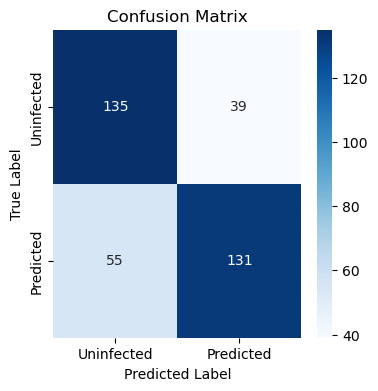

In [22]:
# 6.confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels (y_test) and predicted labels (y_pred) from the code snippet

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Uninfected', 'Predicted'], yticklabels=['Uninfected', 'Predicted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ROC: 0.79


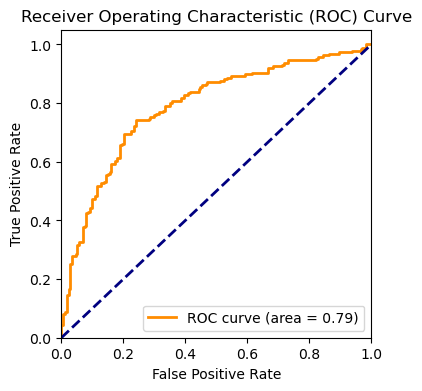

In [23]:
# 7. ROC Curve
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC: {roc_auc:.2f}")
# Plotting ROC Curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


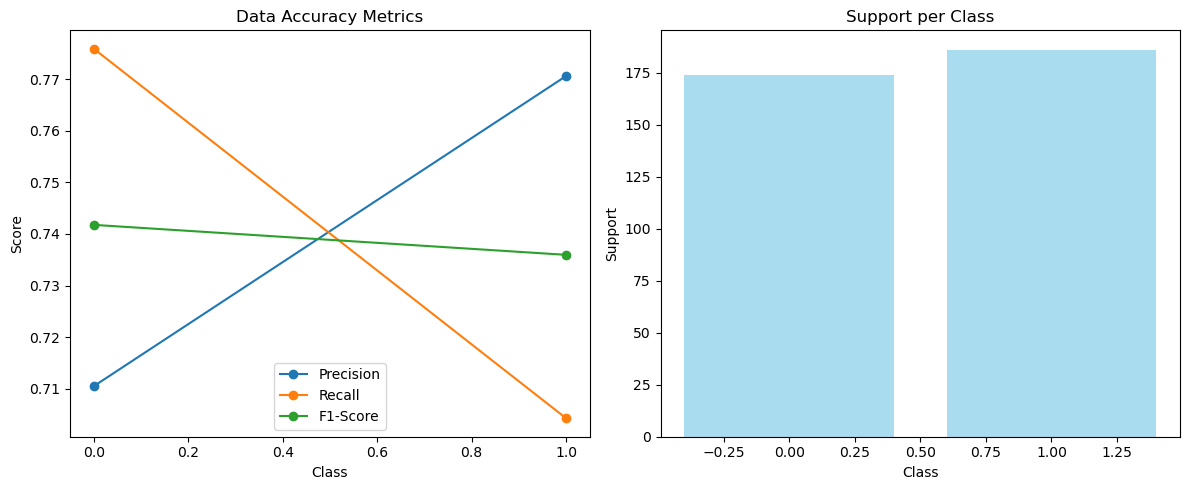

In [24]:
# Other evaluation metrics
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, f1-score, and support from classification report
precision = [report[str(i)]['precision'] for i in range(model.classes_.shape[0])]
recall = [report[str(i)]['recall'] for i in range(model.classes_.shape[0])]
f1_score = [report[str(i)]['f1-score'] for i in range(model.classes_.shape[0])]

# Plot data accuracy (precision, recall, f1-score)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model.classes_, precision, marker='o', label='Precision')
plt.plot(model.classes_, recall, marker='o', label='Recall')
plt.plot(model.classes_, f1_score, marker='o', label='F1-Score')
plt.title('Data Accuracy Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()

# Plot support
plt.subplot(1, 2, 2)
plt.bar(model.classes_, [report[str(i)]['support'] for i in range(model.classes_.shape[0])], color='skyblue', alpha=0.7)
plt.title('Support per Class')
plt.xlabel('Class')
plt.ylabel('Support')

plt.tight_layout()
plt.show()

# k-Means

In [25]:
# Convert cluster assignments to class labels based on majority class
def assign_labels(cluster_labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        assigned_labels = true_labels[cluster_labels == cluster]
        most_common_label = np.argmax(np.bincount(assigned_labels))
        label_mapping[cluster] = most_common_label
    return np.vectorize(label_mapping.get)(cluster_labels)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# 1.Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KMeans with Improved Data
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train_scaled)

# Predict cluster labels for testing set
y_pred_test = kmeans.predict(X_test_scaled)

# Assign Labels and Evaluate
y_pred_test_mapped = assign_labels(y_pred_test, y_test)

accuracy_test = accuracy_score(y_test, y_pred_test_mapped)

print(f"Test Accuracy: {accuracy_test * 100}")

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test_mapped))

D:\Programs\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Test Accuracy: 65.27777777777779
Test Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.89      0.71       174
           1       0.81      0.43      0.56       186

    accuracy                           0.65       360
   macro avg       0.70      0.66      0.64       360
weighted avg       0.70      0.65      0.63       360



In [27]:
# 2.k-fold Cross-Validation
#cv_scores = cross_val_score(kmeans, X_train_scaled, y_train, cv=5)
#print("Cross-Validation Scores:", cv_scores)
#print(f"Mean Cross-Validation Score: {np.mean(cv_scores) * 100}")

Test Confusion Matrix:
[[155  19]
 [106  80]]


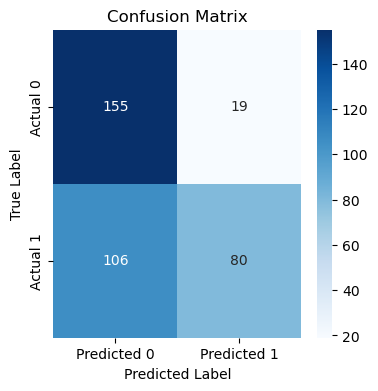

In [28]:
# 3.confusion metrix 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_mapped))
# Assuming you have the true labels (y_test) and predicted labels (y_pred) from the code snippet

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test_mapped)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

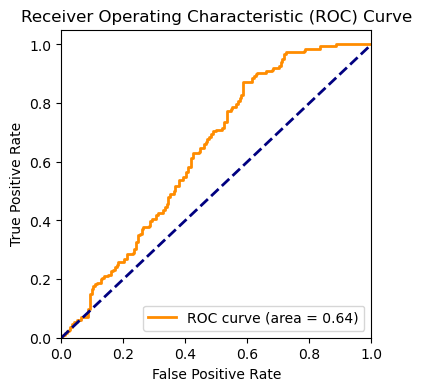

In [29]:
# 4.ROC Curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Get distances to each cluster center for the testing set
distances = kmeans.transform(X_test_scaled).min(axis=1)
fpr, tpr, thresholds = roc_curve(y_test, distances)
roc_auc = auc(fpr, tpr)


# Rest of your code for accuracy and classification report

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, distances)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()